In [1]:
import torch
import torch.nn as nn
import torch.autograd
from torch.autograd import Variable
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.utils.data as data

In [2]:
def class_matrix_generator(annotationsFile, trainBool):
    with open(annotationsFile,'r') as files:
        class_mat = []
        counter = 0
        for line in files:
            counter += 1
            if(counter%100 ==0):
                print("Iteration number %d" %counter)
            #print(line)
            imp,_ = line.split('\n')
            ip,out = imp.split(' ')
            out = out[:-4]+'segcls.png'
            pil_image = np.asarray(Image.open(out))
            #print(pil_image.shape[0])
            #image_ar = np.zeros([pil_image.shape[0],pil_image.shape[1],1])
            image_ar = np.where(pil_image != 0, 1, 0)
            '''for i in range(pil_image.shape[0]):
                for j in range(pil_image.shape[1]):
                    if(np.sum(np.asarray(pil_image)[i][j])!= 0):
                        image_ar[i][j][0]=1'''
            #pil_image = torch.Tensor(pil_image).clamp_(0,1)
            class_mat.append(image_ar)
        if(trainBool):
            np.save('dumps/class_mat_train.npy', np.array(class_mat))
        elif(not trainBool):
            np.save('dumps/class_mat_test.npy',np.array(class_mat))
        else:
            print("Invalid type")
        print("Done")

#class_matrix_generator('/home/shriragk/project/AOI_3_Paris_Train/annotations/trainval.txt', True)
#class_matrix_generator('/home/shriragk/project/AOI_3_Paris_Train/annotations/test.txt', False)

    


In [16]:
class CrossEntropyLoss2d(nn.Module):

    def __init__(self, weight=None):
        super().__init__()

        self.loss = nn.NLLLoss2d(weight)

    def forward(self, outputs, targets):
        return self.loss(F.log_softmax(outputs), targets)

In [17]:
#### cvt2tensor = transforms.ToTensor()
cvt2pil = transforms.ToPILImage()

class Spacenet_Dataset(data.Dataset):
    def __init__(self, annotationsFile,train = True, transform=None, target_transform = None):
        files = open(annotationsFile,'r')
        self.transform=transform
        self.target_transform=target_transform
        items=[]
        #print(lines[0].split('\n'))
        for line in files:
            #print(line)
            imp,_ = line.split('\n')
            ip,out = imp.split(' ')
            out = out[:-4]+'segcls.png'
            
            item = [ip,out]
            items.append(item)
        self.data = items
        self.inp_img_paths=[]
        self.out_img_paths=[]
        for dat in self.data:
            self.inp_img_paths.append(dat[0])
            self.out_img_paths.append(dat[1])
        #print(len(inp_img_paths))
              
    def getImage(self,path):
        pil_image = Image.open(path)
        pil_image = pil_image.convert('RGB')
        return pil_image

    def getImage_out(self,path):
        pil_image = Image.open(path)
        pil_image = pil_image.convert('L')
        image_ar = np.where(np.asarray(pil_image) != 0, 1, 0)
        return image_ar
    
    def __getitem__(self, index):
        cur_in_path = self.inp_img_paths[index]
        cur_out_path = self.out_img_paths[index]
        in_image = self.getImage(cur_in_path)
        out_image = self.getImage_out(cur_out_path)
        
        if self.transform is not None:
            in_image = self.transform(in_image)
            out_image = self.transform(out_image.reshape(650,650,1))
        return in_image, out_image
    
    def __len__(self):
        return len(self.inp_img_paths)

imgTransform = transforms.Compose([transforms.ToTensor()])

trainData = Spacenet_Dataset("/home/shriragk/project/AOI_3_Paris_Train/annotations/trainval.txt",transform=imgTransform)
valData = Spacenet_Dataset("/home/shriragk/project/AOI_3_Paris_Train/annotations/test.txt",transform=imgTransform)
inp,out = trainData[0]
print(inp.size())
print(out.shape)

torch.Size([3, 650, 650])
torch.Size([1, 650, 650])


In [27]:
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        # Convolutional layers.
        self.conv1 = nn.Conv2d(3, 8, 8)
        self.conv2 = nn.Conv2d(8, 16, 6)
        self.conv3 = nn.Conv2d(16, 32, 7)
        self.conv4 = nn.Conv2d(32, 64, 3)
        
        self.deconv1 = nn.ConvTranspose2d(64,32,3)
        self.deconv2 = nn.ConvTranspose2d(32,16,7)
        self.deconv3 = nn.ConvTranspose2d(16,8,6)
        self.deconv4 = nn.ConvTranspose2d(8,1,8)
        
        self.Norm_1 = nn.BatchNorm2d(8)
        self.Norm_2 = nn.BatchNorm2d(16)
        self.Norm_3 = nn.BatchNorm2d(32) 
        self.Norm_4 = nn.BatchNorm2d(64)
        self.Norm_5 = nn.BatchNorm2d(32)
        self.Norm_6 = nn.BatchNorm2d(16)
        self.Norm_7 = nn.BatchNorm2d(8)
        self.Norm_8 = nn.BatchNorm2d(1)
        
        self.pool2 = nn.MaxPool2d(2,return_indices=True)
        self.pool3 = nn.MaxPool2d(3,return_indices=True)
        
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        
        outc1 = F.relu(self.conv1(x))
        outc1 = self.Norm_1(outc1)
        #outc1,c1_in = self.pool2(outc1)
        #print(outc1.size())
        
        outc2 = F.relu(self.conv2(outc1))
        outc2 = self.Norm_2(outc2)
        #outc2,c2_in = self.pool2(outc2)
        #print(outc2.size())
        
        outc3 = F.relu(self.conv3(outc2))
        outc3 = self.Norm_3(outc3)
        #outc3,c3_in = self.pool2(outc3)
        #print(outc3.size())
        
        outc4 = F.relu(self.conv4(outc3))
        outc4 = self.Norm_4(outc4)
        #print(outc4.size())
        
        outd1 = F.relu(self.deconv1(outc4))
        outd1 = self.Norm_5(outd1)
        #print(outd1.size(),c3_in.size())
        #outd1 = self.unpool2(outd1,c3_in)
        
        outd2 = F.relu(self.deconv2(outd1))
        outd2 = self.Norm_6(outd2)
        #print(outd2.size(),c2_in.size())
        #outd2 = self.unpool2(outd2,c2_in)
        
        outd3 = F.relu(self.deconv3(outd2))
        outd3 = self.Norm_7(outd3)
        #print(outd3.size(),c1_in.size())
        #outd3 = self.unpool2(outd3,c1_in)
        
        outd4 = F.relu(self.deconv4(outd3))
        outd4 = self.Norm_8(outd4)
        #outd4 = self.sigmoid(outd4)
        #print(outd4.size())
        
        #return F.upsample_bilinear(outc4, x.size()[2:])
        
        
        return outd4

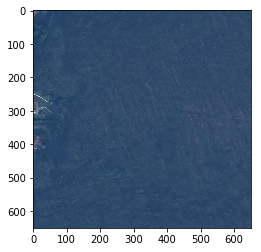

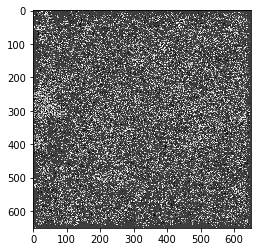

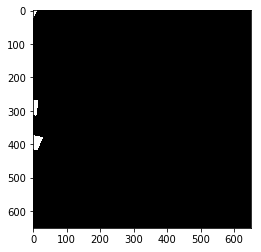

In [28]:
import random

def get_sample(model):
    inp,out = trainData[random.randint(0,917)] # change it to Valdata if necessary, dont forget to change value inside rand()
    inp = inp.view(-1,3,650,650)
    sample_ip = torch.autograd.Variable(inp)
    sample_out = model(sample_ip)
    #print(sample_out.size())
    sample_out = sample_out.view(-1,sample_out.size(2),sample_out.size(3)) * 255
    sample_out = cvt2pil(sample_out.data.cpu()).convert('RGB')
    sample_inp = cvt2pil(inp.view(-1,650,650)) 
    #print(out.shape)
    plt.imshow(sample_inp)
    plt.show()
    plt.imshow(sample_out)
    plt.show()
    plt.imshow(cvt2pil(out.view(-1,650,650) * 255).convert('RGB') )
    plt.show()    
model = MyNet()
get_sample(model)

In [29]:
imgTransform = transforms.Compose([transforms.ToTensor()])

trainData = Spacenet_Dataset("/home/shriragk/project/AOI_3_Paris_Train/annotations/trainval.txt",transform=imgTransform)
valData = Spacenet_Dataset("/home/shriragk/project/AOI_3_Paris_Train/annotations/test.txt",transform=imgTransform)

trainLoader = torch.utils.data.DataLoader(trainData, batch_size = 8, 
                                          shuffle = True, num_workers = 16)
valLoader = torch.utils.data.DataLoader(valData, batch_size = 8, 
                                        shuffle = False, num_workers = 16)

In [37]:
from tqdm import tqdm as tqdm

train_loss=[]
test_loss=[]

def train_rnn_model(model, criterion, optimizer, trainData, valData, n_epochs = 10, use_gpu = False):      
   
    if use_gpu:
        #print('using GPU!')
        model = model.cuda()
        criterion = criterion.cuda()
        
    # Training loop.
    for epoch in range(0, n_epochs):
        cum_loss = 0.0
        accuracy = 0
        
        # Make a pass over the training data.
        t = tqdm(trainData, desc = 'Training epoch %d' % epoch)
        model.train()  # This is important to call before training!
        for (i,(ip_image, out_image)) in enumerate(t): 
            #print(ip_image.size())
            #print(out_image.size())
            input_image = torch.autograd.Variable(ip_image)
            target = torch.autograd.Variable(out_image)
            print(type(target))

            if use_gpu:
                input_image = input_image.cuda()
                target = target.cuda()
            #print(target.size())
            y_ = model(input_image)
            optimizer.zero_grad()
            print(type(target.data))
            loss = criterion(y_, target.view(8,1,-1))
            cum_loss += loss.data[0]

            loss.backward()
                    # Weight and bias updates.
            optimizer.step()                

            # logging information.
            t.set_postfix(loss = cum_loss / (1 + i)) 

        train_loss.append(cum_loss/(i+1))


        # Make a pass over the validation data.
        cum_loss = 0.0
        accuracy = 0
        
        t = tqdm(valData, desc = 'Validation epoch %d' % epoch)
        model.eval()  # This is important to call before evaluating!
        for (i,(ip_image,out_image)) in enumerate(t): 
        
            input_image = torch.autograd.Variable(ip_image)
            target = torch.autograd.Variable(out_image)

            if use_gpu:
                input_image = input_image.cuda()
                target = target.cuda()
                
            y_ = model(input_image)

            loss = criterion(y_, target.view(-1))
            cum_loss += loss.data[0]
            
        test_loss.append(cum_loss/(i+1))
    return model

model = MyNet()
weight = torch.ones(22)
weight[0] = 0
#criterion = CrossEntropyLoss2d(weight.cuda())
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)


# Train the previously defined model.
trained_model = train_rnn_model(nn.DataParallel(model), criterion, optimizer, trainLoader, valLoader, n_epochs = 10, use_gpu = True)









Training epoch 0:   0%|          | 0/115 [00:00<?, ?it/s]

<class 'torch.autograd.variable.Variable'>


<class 'torch.cuda.FloatTensor'>


TypeError: CudaClassNLLCriterion_updateOutput received an invalid combination of arguments - got ([32;1mint[0m, [32;1mtorch.cuda.FloatTensor[0m, [31;1mtorch.cuda.FloatTensor[0m, [32;1mtorch.cuda.FloatTensor[0m, [32;1mbool[0m, [32;1mNoneType[0m, [32;1mtorch.cuda.FloatTensor[0m, [32;1mint[0m), but expected (int state, torch.cuda.FloatTensor input, torch.cuda.LongTensor target, torch.cuda.FloatTensor output, bool sizeAverage, [torch.cuda.FloatTensor weights or None], torch.cuda.FloatTensor total_weight, int ignore_index)

In [ ]:
get_sample(trained_model)

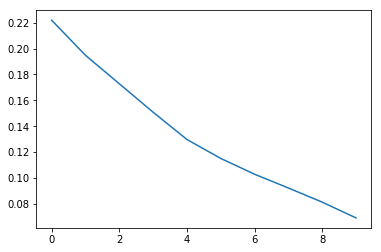

In [21]:
plt.plot(test_loss)
plt.show()